In [28]:
import geopy.geocoders
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy.feature import ShapelyFeature
from shapely.geometry import Point
from functools import partial
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import GoogleV3

%matplotlib notebook

douro_path = "./data_source/douro/"

### Methods Section

In [9]:
def addressGeocoded(df,gc):
    '''
    This function accepts adataframe and a geocode object and returns a geo dataframe
    
    :param df: dataframe with addresses
    :param gc: geocode object
    
    :returns geodataframe
    '''
    tmp_df = df.copy()
    tmp_df['geolocation'] = tmp_df['address'].apply(gc) #translate address into coordinate
    tmp_df['geometry'] = tmp_df['geolocation'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None) #extract tuple point location
    tmp_df['geometry'] = tmp_df['geometry'].apply(Point) # convert tuple in shapely geometry point
    gdf = gpd.GeoDataFrame(tmp_df)
    gdf.set_crs("EPSG:3763", inplace=True) #Set the projection to the ETRS89/PT-TMS09
    gdf.to_file("./data_source/douro/douro_wine_producers.shp")
    return gdf

### Load Datasets

In [31]:
### Laod Portugal Municipalities
pt_municipalities_gdf = gpd.read_file("./data_source/Cont_AAD_CAOP2020/Cont_AAD_CAOP2020.shp")
#pt_municipalities_gdf.shape
#pt_municimunicipalities_gdf.head(15)

In [40]:
print(pt_municipalities_gdf[pt_municipalities_gdf['Concelho']=='Santa Marta de Penaguião'])

     Dicofre                                          Freguesia  \
2274  171101                                  Alvações do Corgo   
2279  171111  União das freguesias de Lobrigos (São Miguel e...   
2282  171106                                            Medrões   
2308  171110                                              Sever   
2349  171112         União das freguesias de Louredo e Fornelos   
2350  171103                                             Fontes   
2358  171102                                           Cumieira   

                      Concelho   Distrito             TAA  Area_T_ha  \
2274  Santa Marta de Penaguião  Vila Real  ÁREA PRINCIPAL     434.36   
2279  Santa Marta de Penaguião  Vila Real  ÁREA PRINCIPAL    1471.42   
2282  Santa Marta de Penaguião  Vila Real  ÁREA PRINCIPAL     514.55   
2308  Santa Marta de Penaguião  Vila Real  ÁREA PRINCIPAL     616.83   
2349  Santa Marta de Penaguião  Vila Real  ÁREA PRINCIPAL    1216.93   
2350  Santa Marta de Penaguião 

In [37]:
### Load Douro Municipalities and parishes
douro_municipalities_parishes_df = pd.read_excel(douro_path+"douro_municipality_parish.xlsx")
douro_municipalities_parishes_df.shape
douro_municipalities_parishes_df.head()

,Area Geografica,Concelhos,Frequesias
0,Baxio Corgo,Mesão Frio,NaN
1,Baxio Corgo,Peso da Régua,NaN
2,Baxio Corgo,Santa Marta de Penaguião,NaN
3,Baxio Corgo,Vila Real,Abaças
4,Baxio Corgo,Vila Real,Ermida


In [50]:
unique_munic = douro_municipalities_parishes_df['Concelhos'].unique()

In [51]:
pt_douro_munic_gdf = pt_municipalities_gdf['Concelho'].apply(lambda muni: muni in unique_munic)

In [4]:
### Load Douro wine producers
douro_wine_producers_df = pd.read_excel(douro_path+"douro_wine_producers_list.xlsx")
douro_wine_producers_df.head(15)

,producer,address
0,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real"
1,Adega Cooperativa de Mesao Frio,"Avenida Dr. Domingos Monteiro Fundo de Vila, 5..."
2,Adega Cooperativa de Sabrosa,"Rua das Flores 27, Alto de Paços, 5060-321 Sab..."
3,Adega Vila Real,"Vale Frio - Folhadela, Vila Real 5000"
4,Aneto,"Quinta do Paco, 5050-090 Godim, Vila Real"
5,Bago de Touriga,"Urb Vila Paulista, 5000-262 Vila Real, Douro"
6,Bom Viver,"Quinta do Espinho, 5030-456 Santa Marta de Pen..."
7,Calheiros Cruz,"Quinta de Covelos, Canelas, 5050 - 426 Peso da..."
8,Caves Transmontanas,"Rua de Sao Domingos 22, 5070 Alijo, Vila Real"
9,Caves Vale do Rodo,"Rua da Lousada, Peso da Regua 5050, Vila Real"


In [5]:
douro_wine_producers_df.shape

(31, 2)

In [6]:
### Instance Google connection for geocoding
geopy.geocoders.options.default_user_agent = 'wine_app'
geopy.geocoders.options.default_scheme = 'https'
with open("./data_source/apikey.txt") as f:   #load Google API key
    apikey = f.readline()
    f.close
geolocator = GoogleV3(api_key=apikey)
geocode = partial(geolocator.geocode, language="en")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
# print(geocode)

In [7]:
douro_wine_producers_gdf = addressGeocoded(douro_wine_producers_df,geocode)

In [15]:
douro_wine_producers_gdf = douro_wine_producers_gdf.drop(columns=['geolocation'])

In [16]:
douro_wine_producers_gdf.head(10)

,producer,address,geometry
0,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real",POINT (41.17185 -7.73081)
1,Adega Cooperativa de Mesao Frio,"Avenida Dr. Domingos Monteiro Fundo de Vila, 5...",POINT (41.15705 -7.89394)
2,Adega Cooperativa de Sabrosa,"Rua das Flores 27, Alto de Paços, 5060-321 Sab...",POINT (41.26240 -7.58068)
3,Adega Vila Real,"Vale Frio - Folhadela, Vila Real 5000",POINT (41.27370 -7.71892)
4,Aneto,"Quinta do Paco, 5050-090 Godim, Vila Real",POINT (41.29160 -7.70775)
5,Bago de Touriga,"Urb Vila Paulista, 5000-262 Vila Real, Douro",POINT (41.31117 -7.72154)
6,Bom Viver,"Quinta do Espinho, 5030-456 Santa Marta de Pen...",POINT (41.20179 -7.78580)
7,Calheiros Cruz,"Quinta de Covelos, Canelas, 5050 - 426 Peso da...",POINT (41.16201 -7.76678)
8,Caves Transmontanas,"Rua de Sao Domingos 22, 5070 Alijo, Vila Real",POINT (41.27245 -7.49902)
9,Caves Vale do Rodo,"Rua da Lousada, Peso da Regua 5050, Vila Real",POINT (41.17405 -7.79597)


In [17]:
#save tmp
#douro_wine_producers_gdf.to_file("./data_source/douro/douro_wine_producers.shp")

In [18]:
### Load Douro shapefile
douro_gdf = gpd.read_file(douro_path+"RDD_ETRS89/RDD_ETRS89.shp")

In [19]:
douro_gdf

,OBJECTID,ID,ÁREA,PERIMETRO,OBSERVAÇÕE,ID1,Shape_area,Shape_len,REGIÃO,Centroid_X,Centroid_Y,geometry
0,1,1.0,2.474209e+09,674115.534151,None,1.0,2.474209e+09,674115.534151,RDD,0,0,"MULTIPOLYGON Z (((-7.76909 41.07097 0.00000, -..."


### Create Douro Map

<IPython.core.display.Javascript object>


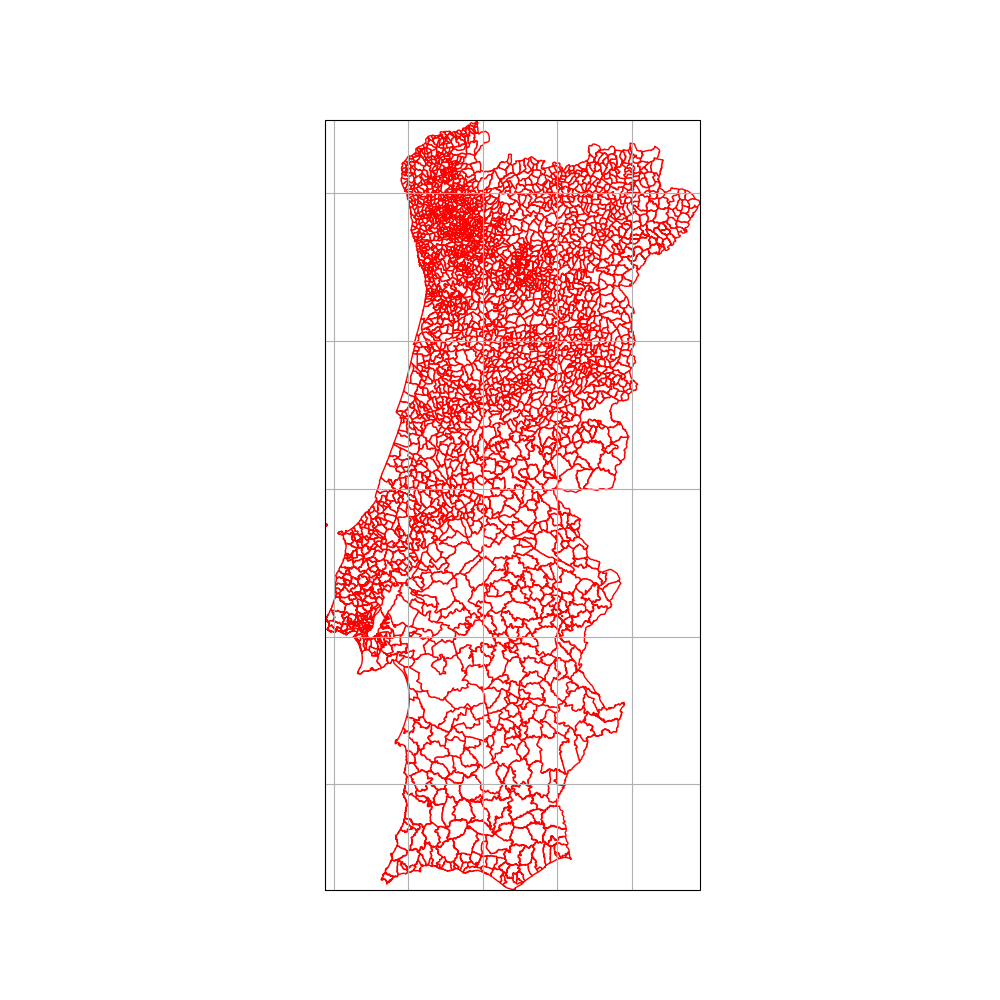

<IPython.core.display.Javascript object>


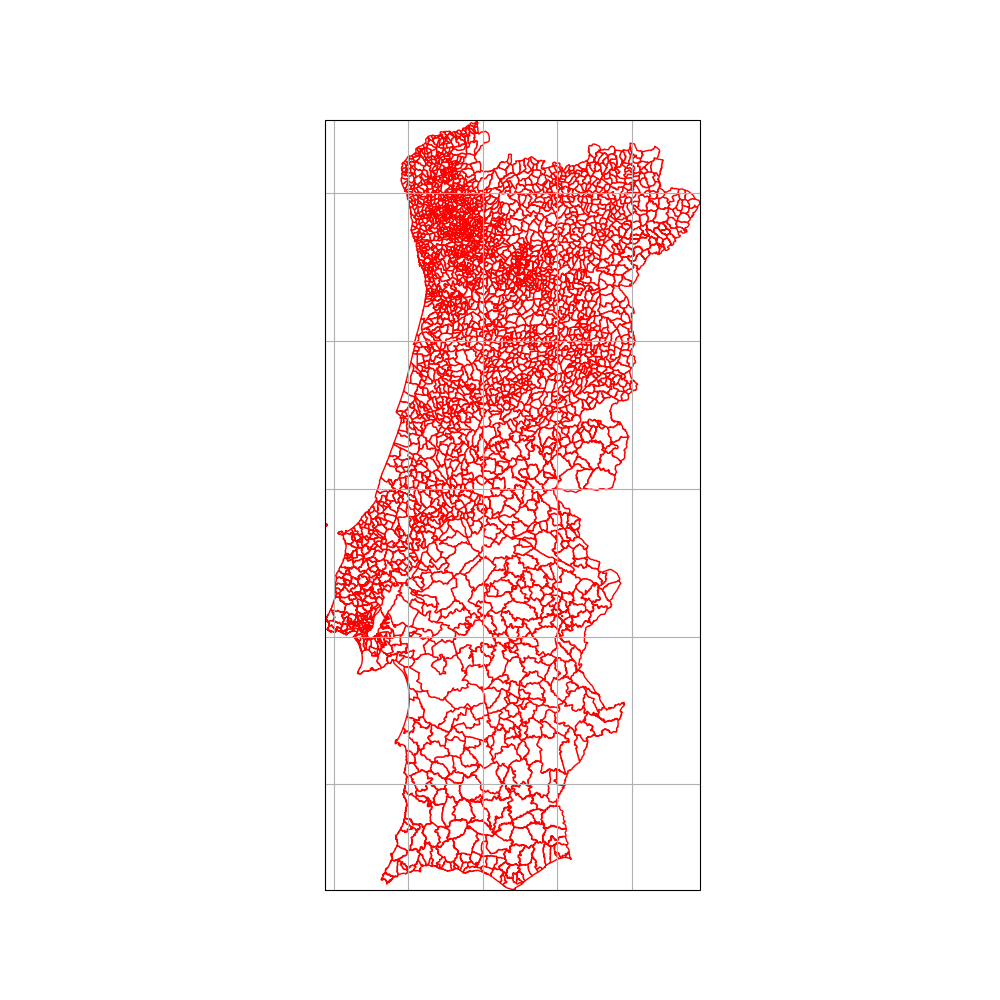

In [23]:
pt_crs = ccrs.UTM(29) #Universal Trasverse Marcator system for Portugal
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection=ccrs.Mercator()) # create axes object with Maractor projection
ax.gridlines()
douro_region = ShapelyFeature(douro_gdf['geometry'], pt_crs, edgecolor='k',linewidth=1.5,facecolor='w')
ax.add_feature(douro_region)# add the douro region borders
xmin, ymin, xmax, ymax = douro_gdf.total_bounds
ax.set_extent([xmin, xmax, ymin, ymax], crs=pt_crs)

ax.scatter(douro_wine_producers_gdf.geometry.y,douro_wine_producers_gdf.geometry.x, color='blue', marker='o',transform=pt_crs)
fig

In [ ]:
# add producers to the map
#plt.plot(, color='k',marker='o', transform=pt_crs)
print(douro_wine_producers_gdf['geometry'].x)
print(douro_wine_producers_gdf['geometry'].y)
ax.plot(41.131039,-8.610935, color='0.5', ms=6, transform=pt_crs)
douro_fig